#### `Data information:`

- `100` genomes (strains) 
- `x3` different treatments (growth conditions)
- `x3` replicates
- plus 300 negative controls (referred to as "blanks")

In [51]:
import pandas as pd
import numpy as np
import glob
import os

# `Data analysis`

![4_Data_analysis.png](images/4_Data_analysis.png)
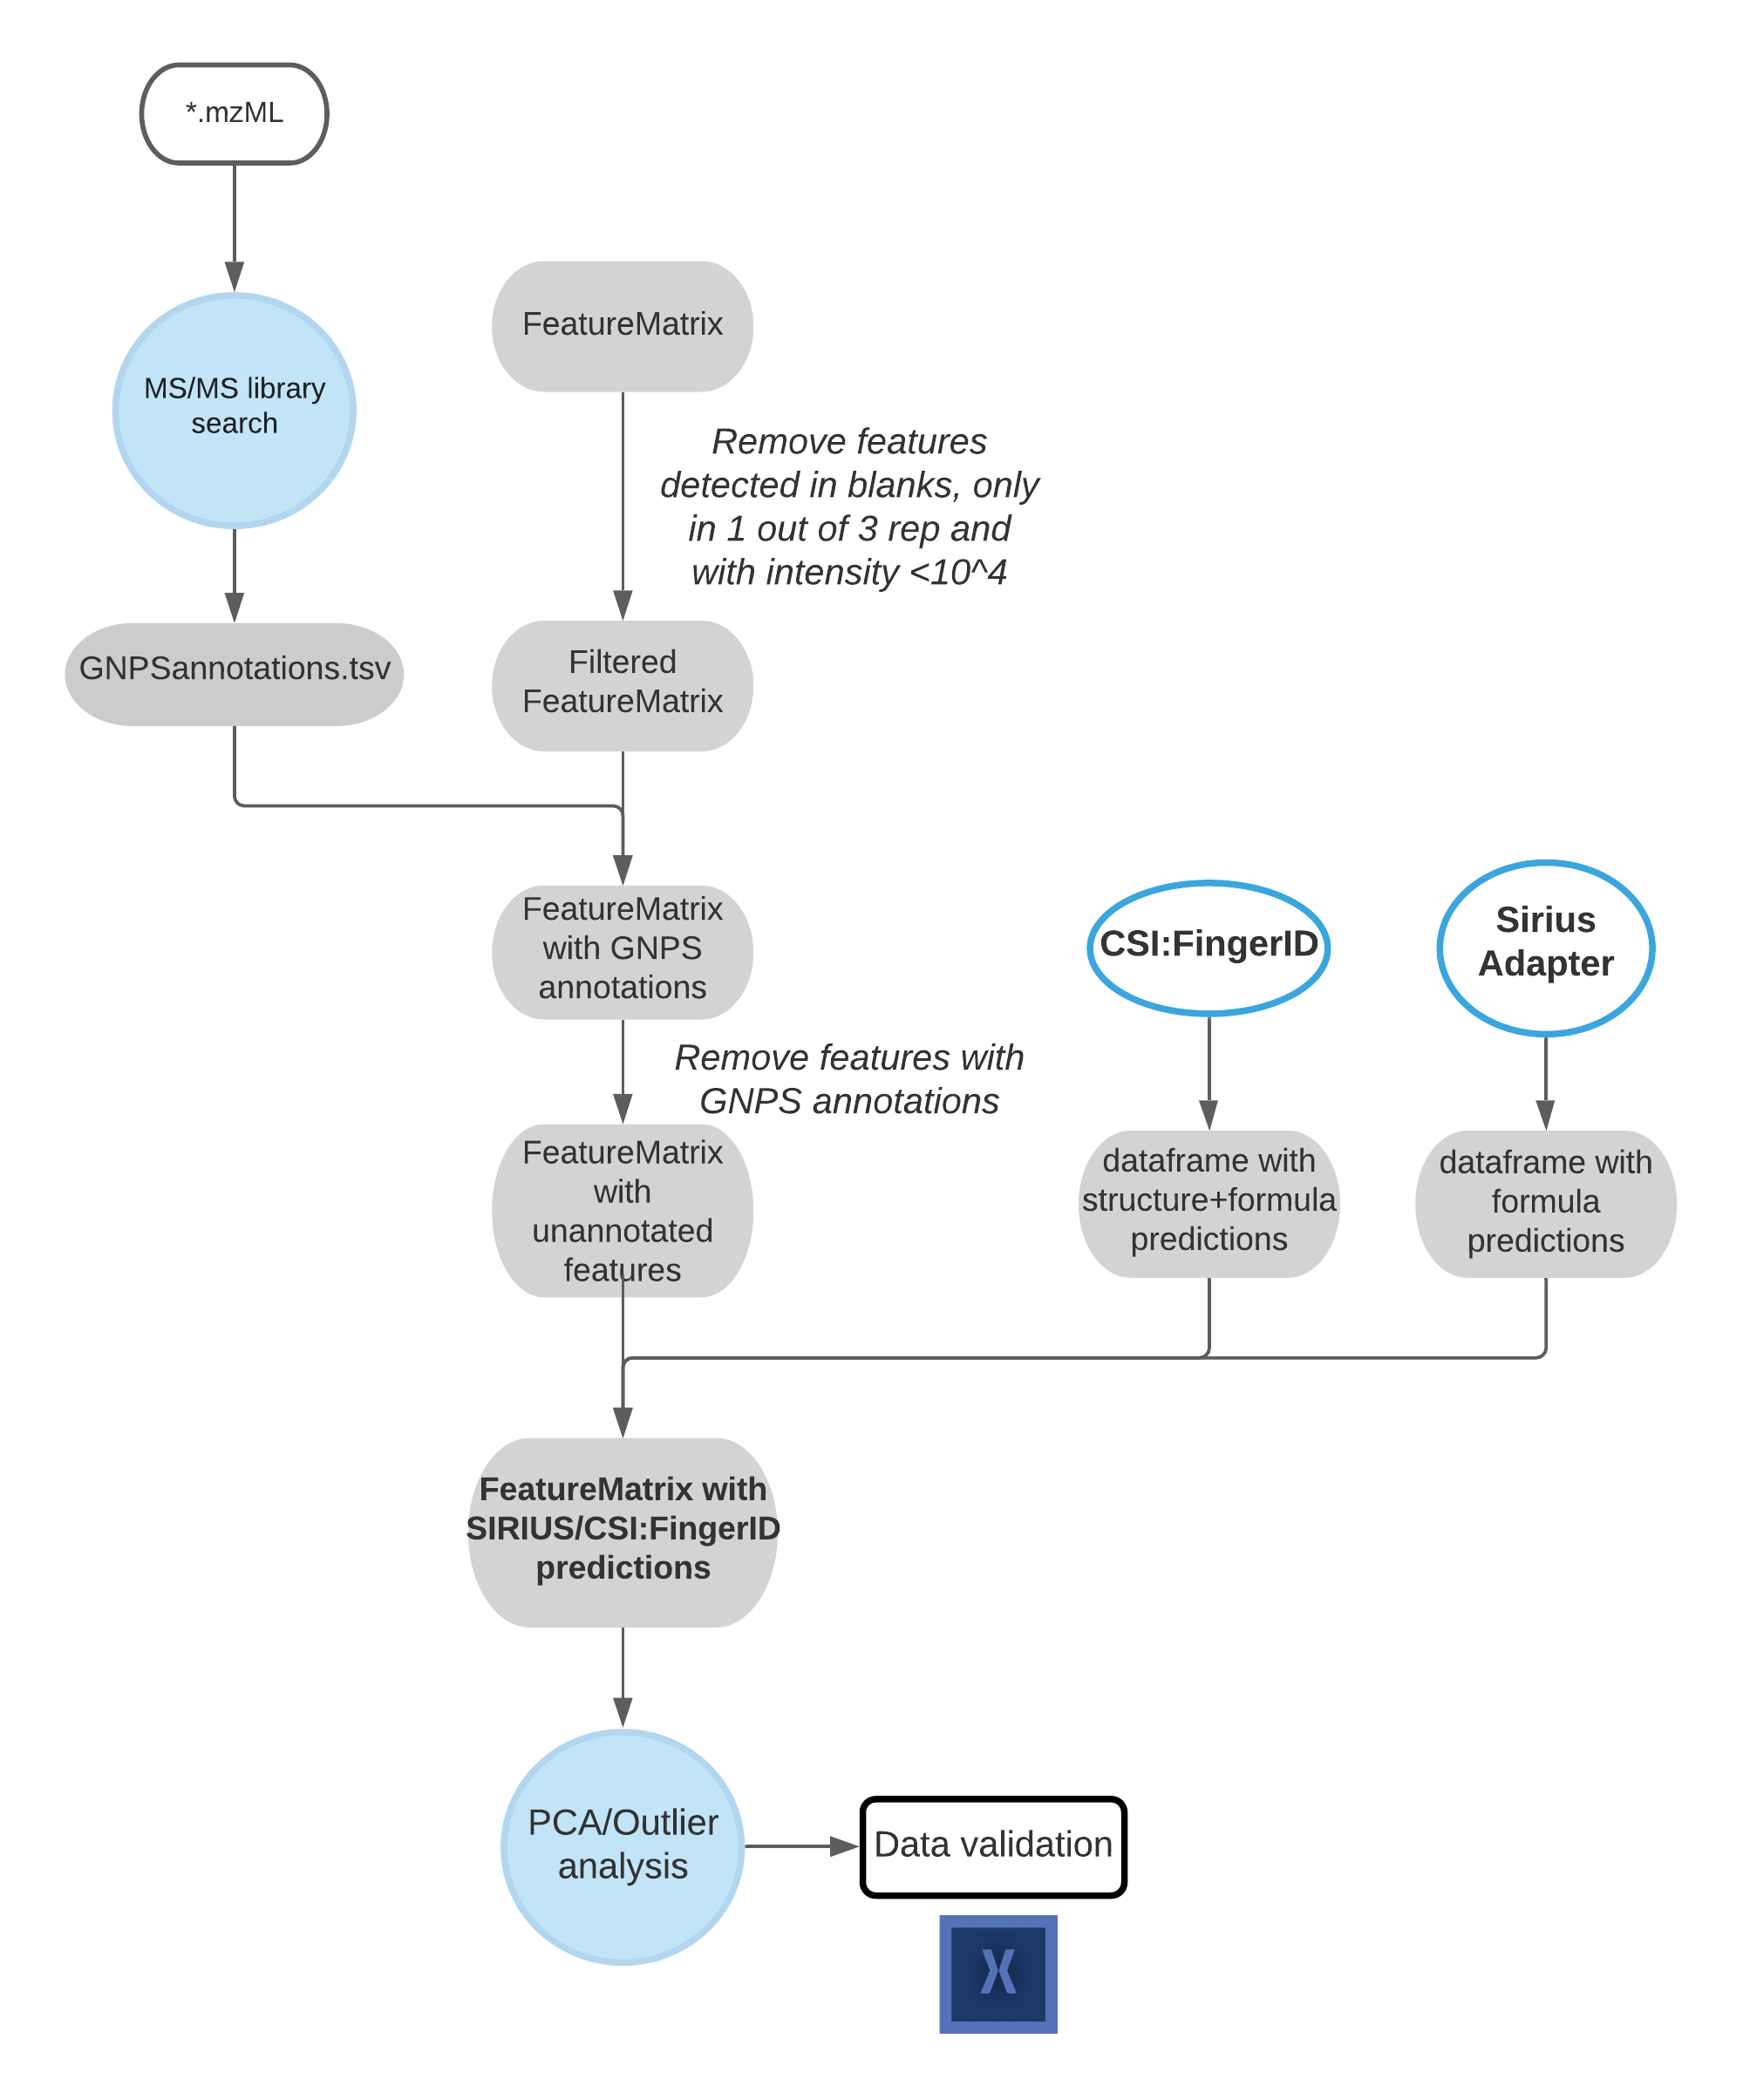

#### `1) Feature Matrix`
Import the feature matrix

In [52]:
FeatureMatrix= "results/features/FeatureMatrix.tsv"
DF_features= pd.read_csv(FeatureMatrix, sep="\t")
DF_features=DF_features.set_index(["mz", "RT"])
DF_features= DF_features.drop(columns="charge")
DF_features

,,20211009_UMETAB222_POS_31_ISP2_Plate-13_NBC_01134_rep3.mzML,20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep1.mzML,20211009_UMETAB222_POS_10_ISP2_Plate-13_NBC_01116_rep1.mzML,20211006_UMETAB222_POS_28_ISP2_Plate-11_NBC_00843_rep3.mzML,20211009_UMETAB222_POS_11_DNPM_Plate-13_NBC_01116_rep1.mzML,20211009_UMETAB222_POS_33_FPY12_Plate-13_NBC_01134_rep3.mzML,20211009_UMETAB222_POS_23_DNPM_Plate-13_NBC_01116_rep2.mzML,20211009_UMETAB222_POS_32_DNPM_Plate-13_NBC_01134_rep3.mzML,20211009_UMETAB222_POS_22_ISP2_Plate-13_NBC_01116_rep2.mzML,20210826_UMETAB219_POS_ISP2_Plate-1_MDNAWGS11_rep1.mzML,20211009_UMETAB222_POS_24_FPY12_Plate-13_NBC_01116_rep2.mzML,20211009_UMETAB222_POS_12_FPY12_Plate-13_NBC_01116_rep1.mzML
mz,RT,,,,,,,,,,,,
228.195786,473.889839,6456007.0,7158484.0,6276594.0,13475320.0,6472127.0,8223848.0,6877668.0,7490720.0,6254406.0,5396077.0,8604468.0,7479438.0
388.263562,637.163227,1488465.0,682178.3,1297476.0,466982.8,1449316.0,1727871.0,1948491.0,1692647.0,1599266.0,1901299.0,1967858.0,0.0
185.092057,78.812706,9785494.0,6814153.0,11802700.0,9691823.0,20620940.0,1585855.0,19825910.0,18193690.0,5129649.0,8052714.0,3993600.0,0.0
195.112804,100.212525,10770410.0,5361819.0,12812270.0,7435392.0,26797860.0,3385145.0,28316300.0,25457100.0,7030839.0,3564171.0,4120325.0,0.0
376.263502,634.989413,11390910.0,5051651.0,11274350.0,3930575.0,12148810.0,13343910.0,15677730.0,14372010.0,12087870.0,16889030.0,16178760.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
506.274841,506.663781,0.0,0.0,0.0,0.0,0.0,1075308.0,0.0,0.0,0.0,0.0,0.0,0.0
638.830580,353.058673,0.0,0.0,0.0,0.0,0.0,3117134.0,0.0,0.0,0.0,0.0,0.0,0.0
768.359788,331.770704,0.0,0.0,0.0,0.0,0.0,942370.8,0.0,0.0,0.0,0.0,0.0,0.0


`Filter the feature matrix`
1) Drop the features detected in more than 50% of the negative controls (blanks)*
###### *Drop the contaminated blanks first

In [53]:
path= "results/interim/analysis"
isExist= os.path.exists(path)
if not isExist:
    os.mkdir(path)

In [54]:
media_list= [r"ISP2", r"FPY12", r"DNPM"] # 3 different media/conditions
for medium in media_list:
    Features_flt=DF_features.filter(regex=fr"{medium}")
    blanks= Features_flt.filter(regex="_blank", axis= 1) 
    contam_list =[r"MDNA_WGS_19", r"MDNA_WGS_25", r"NBC_01304", r"NBC_01250", r"NBC_01245", r"MDNA_WGS_5", r"NBC_00442", r"MDNA_WGS_86", r"NBC_00488", r"NBC_01103", r"NBC_01233", r"NBC_00168", r"MDNA_WGS_53", r"NBC_00990", r"NBC_01054", r"NBC_01127", r"NBC_01048", r"MDNA_WGS_68"] #(cross-)contaminated negative controls
    for contaminated in contam_list:
        contam_blanks= blanks.filter(regex=fr"{contaminated}")
        cols_contam= contam_blanks.columns
    blanks_no_contam= blanks.drop(columns=cols_contam)
    blanks_no_contam= blanks_no_contam.dropna(how="all")
    blanks_no_contam =blanks_no_contam.transpose()
    blanks_no_contam = blanks_no_contam.fillna(0)
    dictionary = {}
    cols= blanks_no_contam.columns
    for i, col in enumerate(cols):
        dictionary[i] = np.count_nonzero(blanks_no_contam[col]) / len(blanks_no_contam[col])
    column_idx = [key for key, value in dictionary.items() if value >= 0.5] #Remove features that appear most frequently (in more than 50% of the samples) in the negative controls
    blank_features= blanks_no_contam.iloc[:, column_idx] 
    cols= blank_features.columns
    Features_flt= Features_flt.transpose()
    Features_nb= Features_flt.drop(columns= cols)
    Features_nb= Features_nb.dropna(how="all")
    Features_nb= Features_nb.transpose()
    Features_nb= Features_nb.reset_index()
    blank_cols= blanks.columns
    Features_nb= Features_nb.drop(columns=blank_cols)
    filename= "results/interim/analysis/"+ medium + "_DF_features_no_blanks.csv"
    Features_nb.to_csv(filename, sep="\t")

2. Replace the features that have lower intensity than 10^4 with NaN (noise for Orbitrap instruments)

In [55]:
def noise_flt(csvfile):   
    Features= pd.read_csv(csvfile, sep="\t", index_col="Unnamed: 0")
    Features= Features.set_index(["mz", "RT"])
    Features= Features.sort_index(axis=1) 
    cols= Features.columns
    Features[cols] = Features[cols].replace({0:np.nan})
    Features[Features<10000] = np.nan
    Featuresnew=Features.dropna(how="all")
    Featuresnew = Featuresnew.fillna(0)
    DF= Featuresnew.reset_index()
    file_path = os.path.join(os.path.dirname(csvfile), 'int_flt_' + os.path.basename(csvfile))
    DF.to_csv(file_path, sep="\t")

In [56]:
csvfiles= glob.glob("results/interim/analysis/*no_blanks.csv")
for csvfile in csvfiles:
    noise_flt(csvfile)

3) Replace the presence of a feature with NaN if the feature is present in only 1 replicate

In [57]:
def rep_filter(csvfile):
    Features= pd.read_csv(csvfile, sep="\t", index_col="Unnamed: 0")
    Features= Features.set_index(["mz", "RT"])
    Features= Features.sort_index(axis=1)
    cols= Features.columns
    Features= Features.fillna(0)
    Features[Features!= 0] = 1 
    Features= Features.transpose()
    Features= Features.reset_index()
    print(Features)
    Features['genomeID']=Features['index'].str.extract(r'(NBC_?\d*)')
    Features['genomeID_MDNA']=Features['index'].str.extract(r'(MDNAWGS?\d*|MDNA_WGS_?\d*)')
    Features['genomeID']=Features['genomeID'].fillna(Features['genomeID_MDNA'])
    Features= Features.drop(columns=["genomeID_MDNA"])
    Features=Features.set_index(["index"])
    Grouped= Features.groupby("genomeID")
    DF= Grouped.transform(lambda x: np.nan if x.sum()<2 else x)
    DF=DF.transpose()
    DF=DF.reset_index()
    file_path = os.path.join(os.path.dirname(csvfile), 'rep_' + os.path.basename(csvfile))
    DF.to_csv(file_path, sep="\t")

In [ ]:
csvfiles= glob.glob("results/interim/analysis/int_flt_*.csv")
for csvfile in csvfiles:
    rep_filter(csvfile)

- Merge all tables on mz and RT:

In [59]:
Matrix_FPY12= pd.read_csv("results/interim/analysis/rep_int_flt_FPY12_DF_features_no_blanks.csv", sep="\t", index_col="Unnamed: 0")
Matrix_ISP2= pd.read_csv("results/interim/analysis/rep_int_flt_ISP2_DF_features_no_blanks.csv", sep="\t", index_col="Unnamed: 0")
Matrix_DNPM= pd.read_csv("results/interim/analysis/rep_int_flt_DNPM_DF_features_no_blanks.csv", sep="\t", index_col="Unnamed: 0")

Matrix_ISP2= Matrix_ISP2.set_index(["mz", "RT"])
Matrix_ISP2= Matrix_ISP2.fillna(0)
Matrix_ISP2= Matrix_ISP2.sort_index(axis=1)

Matrix_FPY12= Matrix_FPY12.set_index(["mz", "RT"])
Matrix_FPY12= Matrix_FPY12.sort_index(axis=1)
Matrix_FPY12= Matrix_FPY12.fillna(0)

Matrix_DNPM= Matrix_DNPM.set_index(["mz", "RT"])
Matrix_DNPM= Matrix_DNPM.fillna(0)
Matrix_DNPM= Matrix_DNPM.sort_index(axis=1)

In [60]:
Matrix_ISP2_FPY12= pd.merge(Matrix_FPY12, Matrix_ISP2, on=["mz", "RT"], how="outer")
Matrix= pd.merge(Matrix_ISP2_FPY12, Matrix_DNPM, on=["mz", "RT"],how= "outer")
cols= Matrix.columns
Matrix[cols] = Matrix[cols].replace({0:np.nan})
Matrix= Matrix.dropna(how="all")
Matrix

,,20211009_UMETAB222_POS_12_FPY12_Plate-13_NBC_01116_rep1.mzML,20211009_UMETAB222_POS_24_FPY12_Plate-13_NBC_01116_rep2.mzML,20211009_UMETAB222_POS_33_FPY12_Plate-13_NBC_01134_rep3.mzML,20210826_UMETAB219_POS_ISP2_Plate-1_MDNAWGS11_rep1.mzML,20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep1.mzML,20211006_UMETAB222_POS_28_ISP2_Plate-11_NBC_00843_rep3.mzML,20211009_UMETAB222_POS_10_ISP2_Plate-13_NBC_01116_rep1.mzML,20211009_UMETAB222_POS_22_ISP2_Plate-13_NBC_01116_rep2.mzML,20211009_UMETAB222_POS_31_ISP2_Plate-13_NBC_01134_rep3.mzML,20211009_UMETAB222_POS_11_DNPM_Plate-13_NBC_01116_rep1.mzML,20211009_UMETAB222_POS_23_DNPM_Plate-13_NBC_01116_rep2.mzML,20211009_UMETAB222_POS_32_DNPM_Plate-13_NBC_01134_rep3.mzML
mz,RT,,,,,,,,,,,,
228.195786,473.889839,1.0,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,1.0,NaN
388.263562,637.163227,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,1.0,NaN
185.092057,78.812706,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,1.0,NaN
195.112804,100.212525,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,1.0,NaN
376.263502,634.989413,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
507.281355,383.981733,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN
1485.641561,487.603805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN
299.163492,52.112255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN


In [61]:
Matrix= Matrix.reset_index()
Matrix.to_csv("results/interim/analysis/Matrix_no_blanks.csv", sep="\t")

`Prepare Matrix for PCA`
- Cluster the different strains (groupby genome ID) and calculate the sum (0.0 no feature detected in all 3 treatments in all 3 replicates - 9.0 feature detected in all 3 treatments in all 3 replicates)

In [62]:
Matrix_IDs= Matrix.fillna(0)
Matrix_IDs= Matrix_IDs.set_index(["mz", "RT"])
Matrix_IDs= Matrix_IDs.sort_index(axis=1)
cols= Matrix_IDs.columns
Matrix_IDs= Matrix_IDs.transpose()
Matrix_IDs= Matrix_IDs.reset_index()
Matrix_IDs['genomeID']=Matrix_IDs['index'].str.extract(r'(NBC_?\d*)')
Matrix_IDs['genomeID_MDNA']=Matrix_IDs['index'].str.extract(r'(MDNAWGS?\d*|MDNA_WGS_?\d*)')
Matrix_IDs['genomeID']=Matrix_IDs['genomeID'].fillna(Matrix_IDs['genomeID_MDNA'])
Matrix_IDs= Matrix_IDs.drop(columns=["genomeID_MDNA"])
Matrix_IDs=Matrix_IDs.set_index(["index"])
Grouped= Matrix_IDs.groupby("genomeID").sum()
Grouped= Grouped.transpose()
Grouped= Grouped.reset_index()
Grouped.to_csv("results/interim/analysis/Grouped_Matrix.csv", sep="\t")
Grouped= Grouped.set_index(["mz", "RT"])
Grouped

/Users/eeko/opt/anaconda3/envs/pyopenms/lib/python3.8/site-packages/pandas/core/generic.py:4150: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



,genomeID,MDNAWGS11,MDNAWGS14,NBC_00843,NBC_01116,NBC_01134
mz,RT,,,,,
228.195786,473.889839,0.0,0.0,0.0,6.0,0.0
388.263562,637.163227,0.0,0.0,0.0,4.0,0.0
185.092057,78.812706,0.0,0.0,0.0,4.0,0.0
195.112804,100.212525,0.0,0.0,0.0,4.0,0.0
376.263502,634.989413,0.0,0.0,0.0,4.0,0.0
...,...,...,...,...,...,...
507.281355,383.981733,0.0,0.0,0.0,2.0,0.0
1485.641561,487.603805,0.0,0.0,0.0,2.0,0.0
299.163492,52.112255,0.0,0.0,0.0,2.0,0.0


In [63]:
FeatureMatrix= pd.read_csv("results/interim/analysis/Grouped_Matrix.csv", sep='\t', index_col="Unnamed: 0")
FeatureMatrix

,mz,RT,MDNAWGS11,MDNAWGS14,NBC_00843,NBC_01116,NBC_01134
0,228.195786,473.889839,0.0,0.0,0.0,6.0,0.0
1,388.263562,637.163227,0.0,0.0,0.0,4.0,0.0
2,185.092057,78.812706,0.0,0.0,0.0,4.0,0.0
3,195.112804,100.212525,0.0,0.0,0.0,4.0,0.0
4,376.263502,634.989413,0.0,0.0,0.0,4.0,0.0
...,...,...,...,...,...,...,...
1317,507.281355,383.981733,0.0,0.0,0.0,2.0,0.0
1318,1485.641561,487.603805,0.0,0.0,0.0,2.0,0.0
1319,299.163492,52.112255,0.0,0.0,0.0,2.0,0.0
1320,1089.492884,530.120348,0.0,0.0,0.0,2.0,0.0


In [64]:
DF_features.to_csv("results/data_analysis/FeatureMatrix_SIRIUS_CSI.csv", sep="\t", index= None)

#### `2) PCA and outlier analysis`

##### `(i) Data pre-treatment`

In [65]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc 

from collections import Counter
#from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#from sklearn.model_delection import ParameterGrid
from sklearn.datasets import load_iris
from sklearn import metrics

In [66]:
Matrix= pd.read_csv("results/interim/analysis/Grouped_Matrix.csv", sep="\t", index_col= "Unnamed: 0")
Matrix= Matrix.set_index(["mz", "RT"])
Matrix= Matrix.transpose()
Matrix

mz,228.195786,388.263562,185.092057,195.112804,376.263502,285.134468,228.170601,506.186885,310.128548,438.197131,...,1152.896549,215.138988,828.390062,823.848144,787.371688,507.281355,1485.641561,299.163492,1089.492884,286.212654
RT,473.889839,637.163227,78.812706,100.212525,634.989413,280.575491,93.787648,69.620378,153.358018,84.264276,...,63.195535,231.780191,316.055608,260.177599,322.533380,383.981733,487.603805,52.112255,530.120348,259.537238
MDNAWGS11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MDNAWGS14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NBC_00843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NBC_01116,6.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
NBC_01134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- `Centering`
    - Import the grouped csv files and perform mean centering to focus on the fluctuating part of the data  

In [67]:
Matrix_centered = Matrix.apply(lambda x: x-x.mean())
Matrix_centered

mz,228.195786,388.263562,185.092057,195.112804,376.263502,285.134468,228.170601,506.186885,310.128548,438.197131,...,1152.896549,215.138988,828.390062,823.848144,787.371688,507.281355,1485.641561,299.163492,1089.492884,286.212654
RT,473.889839,637.163227,78.812706,100.212525,634.989413,280.575491,93.787648,69.620378,153.358018,84.264276,...,63.195535,231.780191,316.055608,260.177599,322.533380,383.981733,487.603805,52.112255,530.120348,259.537238
MDNAWGS11,-1.2,-0.8,-0.8,-0.8,-0.8,-0.8,-0.8,-0.8,-0.8,-0.8,...,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4
MDNAWGS14,-1.2,-0.8,-0.8,-0.8,-0.8,-0.8,-0.8,-0.8,-0.8,-0.8,...,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4
NBC_00843,-1.2,-0.8,-0.8,-0.8,-0.8,-0.8,-0.8,-0.8,-0.8,-0.8,...,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4
NBC_01116,4.8,3.2,3.2,3.2,3.2,3.2,3.2,3.2,3.2,3.2,...,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6
NBC_01134,-1.2,-0.8,-0.8,-0.8,-0.8,-0.8,-0.8,-0.8,-0.8,-0.8,...,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4,-0.4


- Explore if you have outliers with unbiasted skew

In [68]:
Matrix_centered.skew(axis=0, skipna = True)

mz           RT        
228.195786   473.889839    2.236068
388.263562   637.163227    2.236068
185.092057   78.812706     2.236068
195.112804   100.212525    2.236068
376.263502   634.989413    2.236068
                             ...   
507.281355   383.981733    2.236068
1485.641561  487.603805    2.236068
299.163492   52.112255     2.236068
1089.492884  530.120348    2.236068
286.212654   259.537238    2.236068
Length: 1322, dtype: float64

In [69]:
Matrix_centered.describe()

mz,228.195786,388.263562,185.092057,195.112804,376.263502,285.134468,228.170601,506.186885,310.128548,438.197131,...,1152.896549,215.138988,828.390062,823.848144,787.371688,507.281355,1485.641561,299.163492,1089.492884,286.212654
RT,473.889839,637.163227,78.812706,100.212525,634.989413,280.575491,93.787648,69.620378,153.358018,84.264276,...,63.195535,231.780191,316.055608,260.177599,322.533380,383.981733,487.603805,52.112255,530.120348,259.537238
count,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,...,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
mean,4.440892e-17,-4.440892e-17,-4.440892e-17,-4.440892e-17,-4.440892e-17,-4.440892e-17,-4.440892e-17,-4.440892e-17,-4.440892e-17,-4.440892e-17,...,-2.220446e-17,-2.220446e-17,-2.220446e-17,-2.220446e-17,-2.220446e-17,-2.220446e-17,-2.220446e-17,-2.220446e-17,-2.220446e-17,-2.220446e-17
std,2.683282e+00,1.788854e+00,1.788854e+00,1.788854e+00,1.788854e+00,1.788854e+00,1.788854e+00,1.788854e+00,1.788854e+00,1.788854e+00,...,8.944272e-01,8.944272e-01,8.944272e-01,8.944272e-01,8.944272e-01,8.944272e-01,8.944272e-01,8.944272e-01,8.944272e-01,8.944272e-01
min,-1.200000e+00,-8.000000e-01,-8.000000e-01,-8.000000e-01,-8.000000e-01,-8.000000e-01,-8.000000e-01,-8.000000e-01,-8.000000e-01,-8.000000e-01,...,-4.000000e-01,-4.000000e-01,-4.000000e-01,-4.000000e-01,-4.000000e-01,-4.000000e-01,-4.000000e-01,-4.000000e-01,-4.000000e-01,-4.000000e-01
25%,-1.200000e+00,-8.000000e-01,-8.000000e-01,-8.000000e-01,-8.000000e-01,-8.000000e-01,-8.000000e-01,-8.000000e-01,-8.000000e-01,-8.000000e-01,...,-4.000000e-01,-4.000000e-01,-4.000000e-01,-4.000000e-01,-4.000000e-01,-4.000000e-01,-4.000000e-01,-4.000000e-01,-4.000000e-01,-4.000000e-01
50%,-1.200000e+00,-8.000000e-01,-8.000000e-01,-8.000000e-01,-8.000000e-01,-8.000000e-01,-8.000000e-01,-8.000000e-01,-8.000000e-01,-8.000000e-01,...,-4.000000e-01,-4.000000e-01,-4.000000e-01,-4.000000e-01,-4.000000e-01,-4.000000e-01,-4.000000e-01,-4.000000e-01,-4.000000e-01,-4.000000e-01
75%,-1.200000e+00,-8.000000e-01,-8.000000e-01,-8.000000e-01,-8.000000e-01,-8.000000e-01,-8.000000e-01,-8.000000e-01,-8.000000e-01,-8.000000e-01,...,-4.000000e-01,-4.000000e-01,-4.000000e-01,-4.000000e-01,-4.000000e-01,-4.000000e-01,-4.000000e-01,-4.000000e-01,-4.000000e-01,-4.000000e-01
max,4.800000e+00,3.200000e+00,3.200000e+00,3.200000e+00,3.200000e+00,3.200000e+00,3.200000e+00,3.200000e+00,3.200000e+00,3.200000e+00,...,1.600000e+00,1.600000e+00,1.600000e+00,1.600000e+00,1.600000e+00,1.600000e+00,1.600000e+00,1.600000e+00,1.600000e+00,1.600000e+00


- `Standardization`
    - This will make sure that all the features are centred around the mean value with a standard deviation value of 1. This is the best to use if your feature is normally distributed.

In [70]:
import math
def variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)


def stdev(data):
    var = variance(data)
    std_dev = math.sqrt(var)
    return std_dev
    
Matrix_standardized= Matrix_centered.apply(lambda x: (x-x.mean()) / stdev(x))
Matrix_standardized

mz,228.195786,388.263562,185.092057,195.112804,376.263502,285.134468,228.170601,506.186885,310.128548,438.197131,...,1152.896549,215.138988,828.390062,823.848144,787.371688,507.281355,1485.641561,299.163492,1089.492884,286.212654
RT,473.889839,637.163227,78.812706,100.212525,634.989413,280.575491,93.787648,69.620378,153.358018,84.264276,...,63.195535,231.780191,316.055608,260.177599,322.533380,383.981733,487.603805,52.112255,530.120348,259.537238
MDNAWGS11,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,...,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5
MDNAWGS14,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,...,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5
NBC_00843,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,...,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5
NBC_01116,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
NBC_01134,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,...,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5


/Users/eeko/opt/anaconda3/envs/pyopenms/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/Users/eeko/opt/anaconda3/envs/pyopenms/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



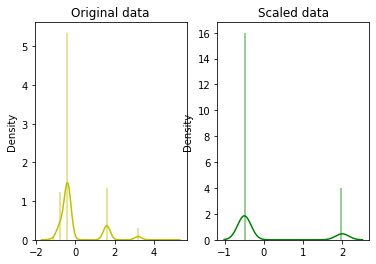

In [71]:
x= Matrix_centered
scaled_data = Matrix_standardized
f, ax = plt.subplots(1,2)
sns.distplot(x, ax=ax[0], color='y')
ax[0].set_title("Original data")
sns.distplot(scaled_data, ax=ax[1], color='g')
ax[1].set_title("Scaled data")
plt.show()

/Users/eeko/opt/anaconda3/envs/pyopenms/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.



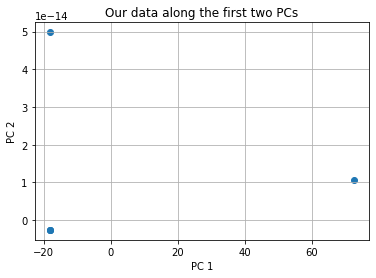

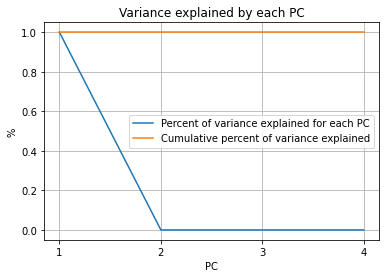

In [72]:
# So, as you know, the principle components of the data are the
# dimensions along which the data varies the most. The data
# here is 4 dimensional (since there are 4 features) and thus
# there are 4 total principle components.

# The first principle component will be the line along which the
# data varies the most. The second will be the line along with the
# data varies the second monst, and so on. The sum of the variances
# of all the principle components will be the entire variance of the
# dataset.

# Okay, so let's use the PCA function to get all 4 principle components.

# As always with the sklearn package, we first have to create and save
# a function "object":
pca = PCA(n_components=4)

# We can actually use this function object to get the first 4 principle
# components of any data. Let's do it for our data:
data_pca = pca.fit_transform(Matrix_standardized)

# Now that we've called fit_transform, the pca object some attributes
# that includes the data points transformed along the principle components.
# So let's plot the data points along the first two principle components.
# We'll use the matplotlib.pyplot package to do this:
plt.scatter(data_pca[:, 0], data_pca[:, 1])
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Our data along the first two PCs")
plt.grid(True)
plt.show()

# The explained variance is also included in the pca object.
# So we can plot that as well:
plt.plot(pca.explained_variance_ratio_,
        label="Percent of variance explained for each PC")
plt.plot([sum(pca.explained_variance_ratio_[:i]) for i in range(1, 5)],
        label="Cumulative percent of variance explained")
plt.legend()
plt.grid(True)
plt.xticks(range(4), ["%0.0f" % i for i in range(1, 5)])
plt.ylabel("%")
plt.xlabel("PC")
plt.title("Variance explained by each PC")
plt.show()

#make a plot where you zoom in
#volcano plots
# So now we see empirical evidence that the sum of all 4 variances
# equals the total variance in the data set (shown by the orange line) :)

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [1322] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


/Users/eeko/opt/anaconda3/envs/pyopenms/lib/python3.8/site-packages/pca/pca.py:941: RuntimeWarning:

invalid value encountered in sqrt



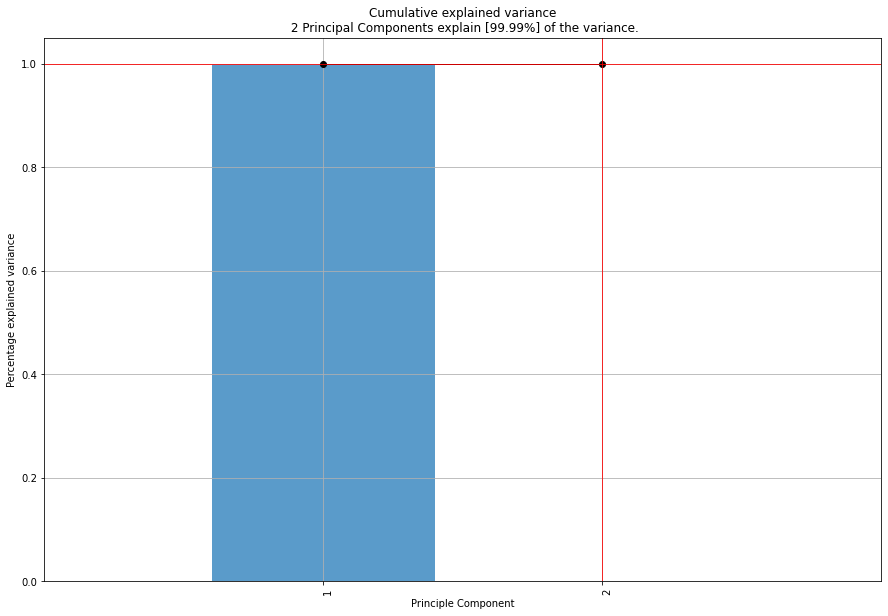

[pca] >Plot PC1 vs PC2 with loadings.


TypeError: can only concatenate tuple (not "str") to tuple

<Figure size 432x288 with 0 Axes>

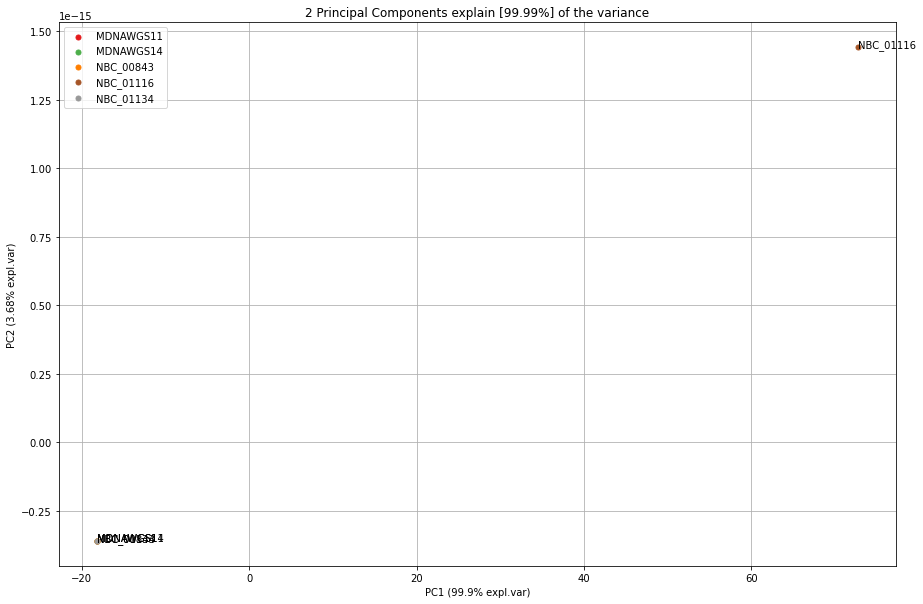

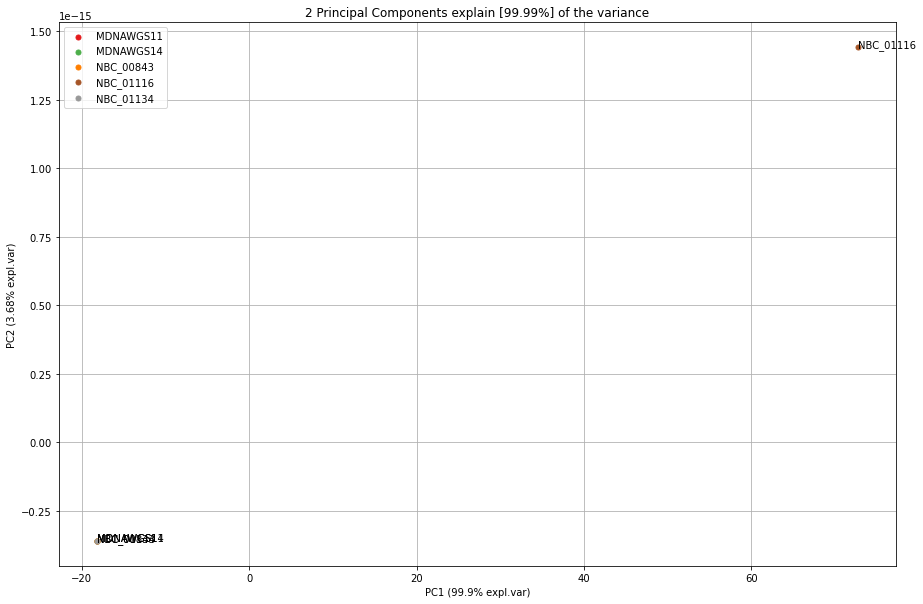

In [73]:
from pca import pca

# Initialize to reduce the data up to the number of componentes that explains 95% of the variance.
model = pca(n_components=0.95)

# Or reduce the data towards 2 PCs
model = pca(n_components=2)

# Fit transform
results = model.fit_transform(Matrix_standardized)

# Plot explained variance
fig, ax = model.plot()

# Scatter first 2 PCs
fig, ax = model.scatter()

# Make biplot with the number of features
fig, ax = model.biplot(n_feat=4)

Interactive PCA plots inspired from https://www.kaggle.com/maniyar2jaimin/interactive-plotly-guide-to-pca-lda-t-sne

In [ ]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.subplots as tls

import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# Import the 3 dimensionality reduction methods
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [ ]:
# Standardize the data
from sklearn.preprocessing import StandardScaler
X = Matrix_standardized.values
X_std = StandardScaler().fit_transform(X)
# Calculating Eigenvectors and eigenvalues of Cov matirx
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eigh(cov_mat) #ASK
# Create a list of (eigenvalue, eigenvector) tuples
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]
# Sort the eigenvalue, eigenvector pair from high to low
eig_pairs.sort(key = lambda x: x[0], reverse= True)

# Calculation of Explained Variance from the eigenvalues
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

In [ ]:
trace1 = go.Scatter(
    x=list(range(10)),
    y= cum_var_exp,
    mode='lines+markers',
    hoverinfo= "all",
    name="'Cumulative Explained Variance'",
    line=dict(
        shape='spline',
        color = 'goldenrod'
    )
)
trace2 = go.Scatter(
    x=list(range(10)),
    y= var_exp,
    hoverinfo= "all",
    mode='lines+markers',
    name="'Individual Explained Variance'",
    line=dict(
        shape='linear',
        color = 'black'
    )
)
fig = tls.make_subplots(insets=[{'cell': (1,1), 'l': 0.7, 'b': 0.3}],
                          print_grid=True)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2,1,1)
fig.layout.xaxis = dict(range=[0, 9.5])
fig.layout.yaxis = dict(range=[0, 110])

py.iplot(fig, filename='inset example')

This is the format of your plot grid:
[ (1,1) x,y ]

With insets:
[ x2,y2 ] over [ (1,1) x,y ]



In [ ]:
X= Matrix_standardized.values

# Standardising the values
X_std = StandardScaler().fit_transform(X)

# Call the PCA method with 50 components. 
pca = PCA(n_components=5)
pca.fit(X_std)
X_5d = pca.transform(X_std)

# For cluster coloring in our Plotly plots, remember to also restrict the target values 
Target = target

In [ ]:
trace0 = go.Scatter(
    x = X_5d[:,0],
    y = X_5d[:,1],
    name = "Target",
    hoverinfo = 'all',
    mode = 'markers',
#     text = Target.unique(),
    showlegend = False,
    marker = dict(
        size = 8,
        color = Target,
        colorscale ='Jet',
        showscale = False,
        line = dict(
            width = 2,
            color = 'rgb(255, 255, 255)'
        ),
        opacity = 0.8
    )
)
data = [trace0]

layout = dict(title = 'PCA (Principal Component Analysis)',
              hovermode= 'closest',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False),
              showlegend= True
             )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-scatter')

In [74]:
Q1=Matrix_standardized.quantile(0.25)
Q3=Matrix_standardized.quantile(0.75)
IQR=Q3-Q1
upper_val= Q3+1.5*IQR
lower_val= Q1-1.5*IQR 

In [ ]:
lower_val.to_csv("lower_val_atratus.csv", sep="\t")
lower_val

mz           RT        
228.195786   473.889839   -0.5
388.263562   637.163227   -0.5
185.092057   78.812706    -0.5
195.112804   100.212525   -0.5
376.263502   634.989413   -0.5
                          ... 
507.281355   383.981733   -0.5
1485.641561  487.603805   -0.5
299.163492   52.112255    -0.5
1089.492884  530.120348   -0.5
286.212654   259.537238   -0.5
Length: 1322, dtype: float64

In [ ]:
upper_val.to_csv("upper_val_atratus.csv", sep="\t")
upper_val

mz           RT        
228.195786   473.889839   -0.5
388.263562   637.163227   -0.5
185.092057   78.812706    -0.5
195.112804   100.212525   -0.5
376.263502   634.989413   -0.5
                          ... 
507.281355   383.981733   -0.5
1485.641561  487.603805   -0.5
299.163492   52.112255    -0.5
1089.492884  530.120348   -0.5
286.212654   259.537238   -0.5
Length: 1322, dtype: float64

In [ ]:
Matrix_standardized= Matrix_standardized.transpose()
Matrix_standardized= Matrix_standardized.reset_index()
Matrix_standardized

,mz,RT,MDNAWGS11,MDNAWGS14,NBC_00843,NBC_01116,NBC_01134
0,228.195786,473.889839,-0.5,-0.5,-0.5,2.0,-0.5
1,388.263562,637.163227,-0.5,-0.5,-0.5,2.0,-0.5
2,185.092057,78.812706,-0.5,-0.5,-0.5,2.0,-0.5
3,195.112804,100.212525,-0.5,-0.5,-0.5,2.0,-0.5
4,376.263502,634.989413,-0.5,-0.5,-0.5,2.0,-0.5
...,...,...,...,...,...,...,...
1317,507.281355,383.981733,-0.5,-0.5,-0.5,2.0,-0.5
1318,1485.641561,487.603805,-0.5,-0.5,-0.5,2.0,-0.5
1319,299.163492,52.112255,-0.5,-0.5,-0.5,2.0,-0.5
1320,1089.492884,530.120348,-0.5,-0.5,-0.5,2.0,-0.5


In [ ]:
upper_val= pd.read_csv("upper_val", sep="\t")
Matrix_scaled= pd.merge(Matrix_standardized, upper_val, on="Feature_ID")
Matrix_scaled= Matrix_scaled.set_index("Feature_ID")
Matrix_scaled= Matrix_scaled.round(decimals=5)
Matrix_scaled

In [ ]:
lower_val= pd.read_csv("lower_val.csv", sep="\t")
Matrix_scaled= pd.merge(Matrix_scaled, lower_val, on="Feature_ID")
Matrix_scaled= Matrix_scaled.set_index("Feature_ID")
Matrix_scaled= Matrix_scaled.round(decimals=5)
Matrix_scaled

Only investigate the rarely occuring metabolites:

In [ ]:
Matrix_standardized=Matrix_standardized.set_index("Feature_ID")
cols= Matrix_standardized.columns
outliers=Matrix_scaled

for col in cols:
    for idx in outliers.index:
        if outliers["Lower_limit"][idx]<= outliers[col][idx]:
            outliers.loc[idx, col]=np.nan

outliers

In [ ]:
outliers= outliers.drop(columns=["Upper_limit", "Lower_limit"])
outliers= outliers.dropna(how="all")
outliers= outliers.transpose()
outliers= outliers.dropna(how="all")
outliers= outliers.transpose()
outliers.to_csv("outliers.csv", sep="\t")
outliers

In [ ]:
df_new= df.reset_index()
df_new= df_new.filter(["mz", "RT", "Feature_ID"])
df_new

`Outlier GNPS annotation`

In [ ]:
df= pd.read_csv("resources/MS2_LIBRARYSEARCH_all_identifications.tsv", sep='\t', encoding='latin-1')
df.drop(df.index[df['IonMode'] == "negative"], inplace=True)
df.drop(df.index[df['MZErrorPPM'] > 20.0], inplace=True)
GNPS=df.drop(columns=["PI", "Adduct", "IonMode", "Organism", "MZErrorPPM", "SpecMZ"])
GNPS=GNPS.rename(columns= {"RT_Query": "RetentionTime"})
GNPS=GNPS.drop_duplicates(subset="Compound_Name", keep='first')
GNPS

,Compound_Name,Precursor_MZ,RetentionTime
0,dehydroxynocardamine,585.361000,347.70300
2,Massbank:PR311142 Cyclo(leucylprolyl),211.144000,200.44700
6,cyclo(L-Val-L-Pro),197.129000,311.23700
8,"""(4R)-4-((3R,5R,6S,7R,9S,10R,12S,13R,17R)-3,6,...",871.554000,419.38900
9,Massbank:PR300821 Cyclo(proline-leucine),211.144000,223.96100
...,...,...,...
356761,Spectral Match to Tyr-Ala from NIST14,253.118000,76.97570
357126,epemicinA,793.446100,412.72450
357127,epemicinB,712.420400,405.53937
357128,"epemicinB, M+H",1423.832300,405.53937


In [ ]:
outliers_df.insert(0, 'GNPS_IDs', '')

for i, mz, rt in zip(outliers_df.index, outliers_df['mz'], outliers_df['RT']):
    hits = []
    for name, GNPS_mz, GNPS_rt, in zip(GNPS['Compound_Name'], GNPS['Precursor_MZ'], GNPS['RetentionTime']):
        mass_delta = (abs(GNPS_mz-mz)/GNPS_mz)*1000000.0 if GNPS_mz != 0 else np.nan
        if (GNPS_rt >= rt-30.0) & (GNPS_rt <= rt+30.0) & (mass_delta<= 20.0):
            hit = f'{name}'
            if hit not in hits:
                hits.append(hit)
    outliers_df['GNPS_IDs'][i] = ' ## '.join(hits)

outliers_df.to_csv("GNPS_annotated_outliers.tsv", sep='\t', index = False)
outliers_df

In [ ]:
outliers_df= outliers_df[outliers_df.GNPS_IDs == '']
outliers_df= outliers_df.drop(columns= "GNPS_IDs")
outliers_df= outliers_df.set_index(["mz", "RT"])
outliers_df_tocsv= outliers_df.reset_index()
outliers_df_tocsv.to_csv("outliers_df_unknowns.tsv", sep="\t", index =None)
outliers_df

In [ ]:
df= df.drop(columns="Feature_ID")
cols=outliers_df.columns
idx=outliers_df.index
df= df.filter(cols)
df

In [ ]:
df=df.loc[idx]
df

In [ ]:
df= df.transpose()
df_csv= df.reset_index()
df_csv.to_csv("df_outlier_ft.csv", sep="\t")

In [ ]:
import pandas as pd
atratus= pd.read_csv("df_outlier_ft.csv", sep="\t", index_col= "Unnamed: 0")
atratus= atratus.set_index(["mz", "RT"])
atratus